# OASIS Dementia Classification AI

By Neil G, Nishanth K, Jacob B, and Daniel D

### Imports

In [1]:
import tensorflow as tf
import numpy as np
import keras
import os
import matplotlib.pyplot as plt
import random

from keras import layers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.saving.save import load_model

### Setting Up the GPU Environment

We first ensure that a GPU is present on the machine used.

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

We then limit GPU memory growth to only allocate as much GPU memory as needed during runtime. Basically, we ensure that Tensorflow dynamically updates the necessary GPU memory to prevent Tensorflow from using all of the memory available at once. To avoid memory fragmentation, no memory is released.

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), 'Physical GPUs,', len(logical_gpus), 'Logical GPUs')
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Preparing the Data

We set global variables representing the image width and height.

In [4]:
img_width = 124
img_height = 62

Part of the data has already been processed (see the `npz.generator.py` file). The OASIS dataset contains 61 slices of the MRI images per patient. We took each set of a patient's MRI slices and stacked them into a 3D design. We downsized the images to the sizes defined above and converted to grayscale (since MRI images are effectively already in grayscale), to save memory and training time, as well as reducing model complexity. These stacked 3D tensors were stored in a different directory as `.npz` files. We collect the examples and labels to then make a Tensorflow dataset out of them. It is important to note that some of the data classes were amplified by duplicating the `.npz` data in order to provide more samples (namely, for the moderate dementia class). 

In [5]:
path = 'Stacked'

i = 0
examples = []
labels = []
for fp in sorted(os.listdir(path)):
    if fp.startswith('.'):
        continue
    for f in sorted(os.listdir(os.path.join(path, fp))):
        if f.startswith('.'):
            continue
        with np.load(os.path.join(path, fp, f)) as data:
            features = data['arr_0']
            examples.append(features)
            labels.append(i)
    i += 1

shape = len(examples)
print(shape)

1669


We zip the examples and labels and then shuffle them with a set random seed of 42. We zip the lists to ensure that the example and label match up in the returned list (so that way the right label is with the right example). We then split the lists manually into train and test sets, using 80% for training. We then make a Tensorflow dataset from the train and test tensor slices. We delete some of the lists to save memory (note: `gc.collect()` was not called).

In [6]:
temp = list(zip(examples, labels))
random.Random(42).shuffle(temp)
res1, res2 = zip(*temp)
res1, res2 = list(res1), list(res2)

train_examples = res1[:int(0.8*len(res1))]
train_labels = res2[:int(0.8*len(res2))]
test_examples = res1[int(0.8*len(res1)):]
test_labels = res2[int(0.8*len(res2)):]

ds_train = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
ds_test = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))

del examples, labels, res1, res2, temp

We batch the train dataset in batches of 16 and then shuffle the train dataset once again with a set seed.

In [7]:
batch_size = 16

ds_train = ds_train.batch(batch_size).shuffle(seed=42, buffer_size=1250)

### Model Design

We utilize Tensorflow's functional API to make this model. We take an input layer of the image height and image width, each having 61 slices per patient, and 1 extra channel for the grayscale value. We pass this input layer into two sets of 3 layers, containing a Conv3D, MaxPool3D, and BatchNormalization layer. We then pass that functional model into a GlobalAveragePooling3D layer and then two Dense layers, with the second having 4 units to come to a conclusion. The model is created and summarized.

In [8]:
inputs = layers.Input(shape=(img_height, img_width, 61, 1))

x = layers.Conv3D(filters=16, kernel_size=3, activation='relu')(inputs)
x = layers.MaxPool3D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv3D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPool3D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

x = layers.GlobalAveragePooling3D()(x)
x = layers.Dense(units=64, activation='relu')(x)

outputs = layers.Dense(units=4, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 62, 124, 61, 1)]  0         
                                                                 
 conv3d (Conv3D)             (None, 60, 122, 59, 16)   448       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 30, 61, 29, 16)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 30, 61, 29, 16)   64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 28, 59, 27, 32)    13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 14, 29, 13, 32)   0     

We then train the model using the Adam optimizer with a learning rate of 0.01. We use SparseCategoricalCrossentropy for the loss, and we track accuracy. We add two callbacks to the model: an EarlyStopping callback monitoring the loss with a patience value of 5, stopping the training if the loss isn't decreasing, and a ModelCheckpoint callback that saves the best model from training. We then fit the model to the train dataset for 50 epochs. We save the model as well.

In [9]:
model.compile(optimizer=Adam(learning_rate=.01), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

metric = 'loss'
callbacks = [EarlyStopping(monitor=metric, patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor=metric, save_best_only=True)]
history = model.fit(ds_train, epochs=50, verbose=1, callbacks=callbacks)

model.save('models/hvair_4')

Epoch 1/50
84/84 [==============================] - 26s 177ms/step - loss: 0.7894 - accuracy: 0.6944
Epoch 2/50
84/84 [==============================] - 14s 165ms/step - loss: 0.6407 - accuracy: 0.7251
Epoch 3/50
84/84 [==============================] - 14s 164ms/step - loss: 0.5837 - accuracy: 0.7536
Epoch 4/50
84/84 [==============================] - 14s 164ms/step - loss: 0.4932 - accuracy: 0.7925
Epoch 5/50
84/84 [==============================] - 14s 167ms/step - loss: 0.4541 - accuracy: 0.8150
Epoch 6/50
84/84 [==============================] - 14s 167ms/step - loss: 0.4386 - accuracy: 0.8292
Epoch 7/50
84/84 [==============================] - 14s 166ms/step - loss: 0.3850 - accuracy: 0.8442
Epoch 8/50
84/84 [==============================] - 14s 167ms/step - loss: 0.3422 - accuracy: 0.8637
Epoch 9/50
84/84 [==============================] - 14s 164ms/step - loss: 0.3255 - accuracy: 0.8712
Epoch 10/50
84/84 [==============================] - 14s 167ms/step - loss: 0.3153 - accura

INFO:tensorflow:Assets written to: models/hvair_4\assets


INFO:tensorflow:Assets written to: models/hvair_4\assets


### Results

We plot the model accuracy as a function of epochs. Below, we do the same for model loss as a function of epochs. The curves for both look as expected (increasing at decreasing rate for accuracy and decreasing at a decreasing rate for loss).

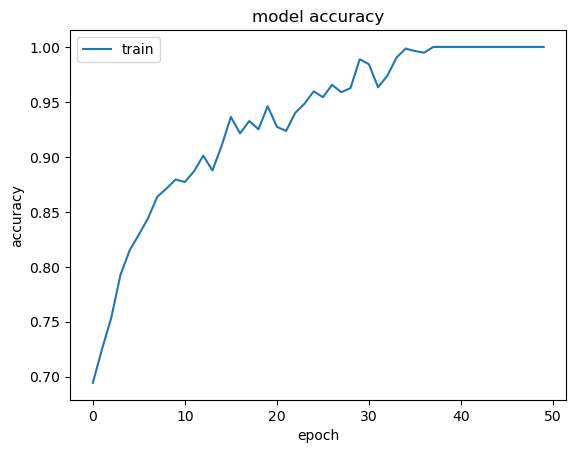

In [10]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('accuracy.png')
plt.show()

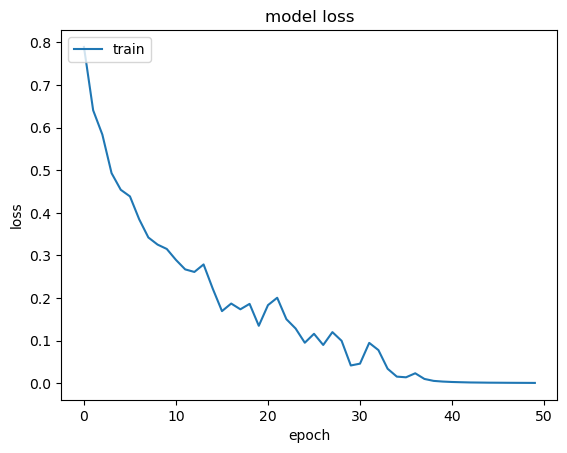

In [11]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss.png')
plt.show()

To check our model performance, we finally employ the test set. We test the test set on the best model, yielding an accuracy of 0.9731, an awesome result, meaning our model is a good fit of the data!

In [12]:
best_model = load_model('best_model.h5')
best_model.evaluate(ds_test.batch(1))

334/334 [==============================] - 2s 5ms/step - loss: 0.0769 - accuracy: 0.9731


[0.07689814269542694, 0.9730538725852966]